## Assignment 1 - Image Classification

## -1. Runtime environment
I ran the project on my own computer in my own environment built using python venv using CUDA.

In [16]:
# python -m venv venv
# venv\Scripts\activate
# pip install numpy
# pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# pip install torchvision
# pip install torchsummary
# pip install pandas
# pip install jupyter
# pip install graphviz
# pip install matplotlib
# pip install IPython
# pip install sklearn
# pip install seaborn
# pip install pretty_confusion_matrix

# jupyter notebook

In [17]:
!nvidia-smi

Mon Oct 23 20:33:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   36C    P8               1W /  50W |    368MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # customize the training
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore") 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

### The dataset's structure.
My dataset was the Fruits 360 dataset with images from fruits and vegetables. There was 131 classes. I chose 2x5 classes from these. I deleted all the remains datas. The fruits360 folder contains a train, val, test folders for the cases.

The selected classes: 

    Apples only: fruits360_apples -> braeburn, crimson, golden, granny, pink_lady 
    
    Mixed fruits, veggys: fruits360_mix -> apple, carrot, cucumber, pear, zucchini
    

#### Check the number of images and class balances in the  train, validation and test set

#### Splitting the dataset

The datasets ar pre splitted:

Apples only:

    The part sizes: fruits360_apples -> train: 1579, val: 789, test: 789
    
Mixed fruits:

    The part sizes: fruits360_mix -> train: 996, val: 497, test: 496

### Batch_size
I have a 4GB GPU, for this size the 64 batch seemed size is ideal for two modells and a correct running time.

#### Pre-processing the dataset (data loader with transformations)

In [19]:
Batch_size=64;

#Size 224 is ideal for ResNet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'fruits360_apples'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print("Readed classes: ")
print(class_names)
print("Readed dataset sizes: ")
print(dataset_sizes)

Readed classes: 
['braeburn', 'crimson', 'golden', 'granny', 'pink_lady']
Readed dataset sizes: 
{'train': 1579, 'val': 789, 'test': 789}


#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

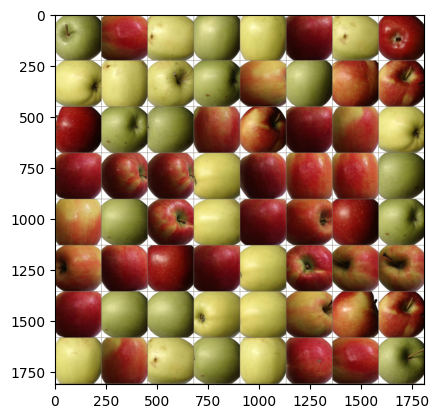

In [21]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

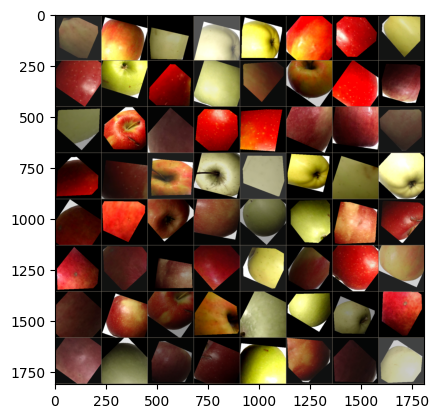

In [22]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

#### Load the given pre-trained model

In [23]:
model = models.resnet18()

#### Summary of the given pre-trained model

ResNet18 Architecture

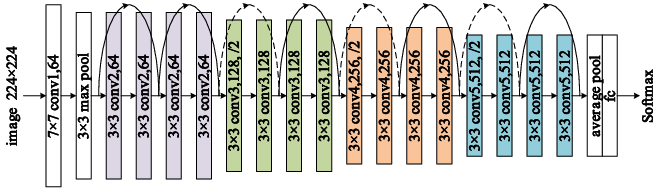

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Create the model trainer method.

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_h=[]
    train_acc_h=[]
    for epoch in range(num_epochs):
      
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_acc_h.append(epoch_acc)
            # deep copy the model
            if phase == 'val':
                val_acc_h.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

        print('Test started')
    phase == 'test'
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        test_loss = running_loss / dataset_sizes[phase]
        test_acc = running_corrects.double() / dataset_sizes[phase]
        
    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_h, train_acc_h, test_acc

### Build the basic model.

In [26]:
model = models.resnet18()
numrs = model.fc.in_features

model.fc = nn.Linear(numrs, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
### Run the training

In [28]:
model, val_acc_h, train_acc_h, test_acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.000100
----------
train Loss: 0.9441 Acc: 0.5636
val Loss: 2.1697 Acc: 0.3156
Test started
Epoch 1/9 LR 0.000100
----------
train Loss: 0.7400 Acc: 0.6700
val Loss: 0.7243 Acc: 0.6502
Test started
Epoch 2/9 LR 0.000100
----------
train Loss: 0.6645 Acc: 0.6979
val Loss: 0.4382 Acc: 0.8048
Test started
Epoch 3/9 LR 0.000100
----------
train Loss: 0.5699 Acc: 0.7549
val Loss: 0.3995 Acc: 0.8264
Test started
Epoch 4/9 LR 0.000100
----------
train Loss: 0.5328 Acc: 0.7695
val Loss: 0.3601 Acc: 0.8289
Test started
Epoch 5/9 LR 0.000100
----------
train Loss: 0.5264 Acc: 0.7809
val Loss: 0.2415 Acc: 0.9125
Test started
Epoch 6/9 LR 0.000100
----------
train Loss: 0.4643 Acc: 0.7980
val Loss: 0.3550 Acc: 0.8314
Test started
Epoch 7/9 LR 0.000010
----------
train Loss: 0.4598 Acc: 0.8284
val Loss: 0.1644 Acc: 0.9442
Test started
Epoch 8/9 LR 0.000010
----------
train Loss: 0.3696 Acc: 0.8474
val Loss: 0.1295 Acc: 0.9696
Test started
Epoch 9/9 LR 0.000010
----------
train Loss: 0

## Plot the training

In [29]:
def plot_acc(train_acc_h,val_acc_h, test_acc): 
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(val_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(test_acc, device = 'cpu')*100*np.ones(len(val_acc_h)))
    plt.ylim((50,100))
    plt.legend(['train', 'valid', 'test'])

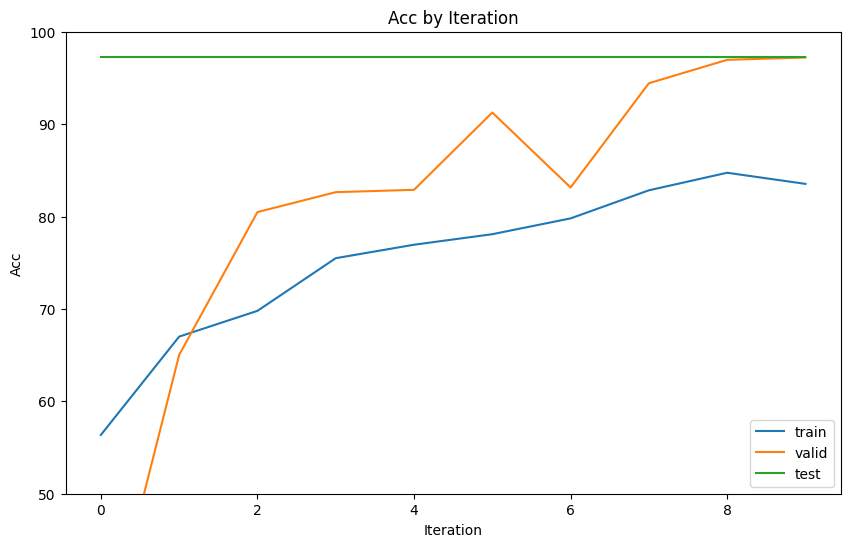

In [30]:
plot_acc(train_acc_h,val_acc_h, test_acc)

### Visualize the resoults

In [51]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

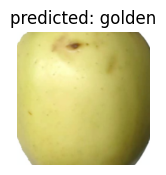

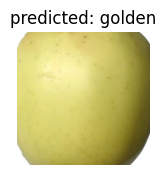

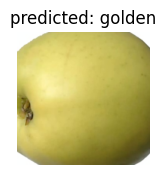

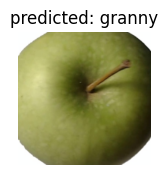

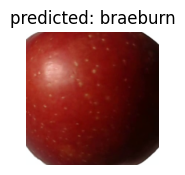

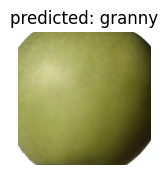

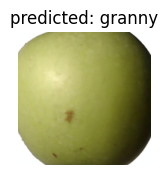

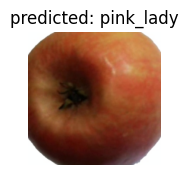

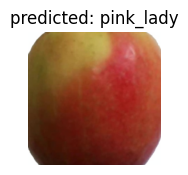

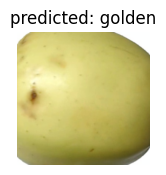

In [52]:
visualize_model(model)

#### Implement the new architecture with less parameter

In [53]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # BinaryCrossEntropyLoss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
model_ft, val_acc_h, train_acc_h, test_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.001000
----------
train Loss: 1.2260 Acc: 0.5117
val Loss: 0.6513 Acc: 0.7072
Test started
Epoch 1/9 LR 0.001000
----------
train Loss: 0.5461 Acc: 0.8309
val Loss: 0.2166 Acc: 0.9886
Test started
Epoch 2/9 LR 0.001000
----------
train Loss: 0.3103 Acc: 0.9037
val Loss: 0.1402 Acc: 0.9582
Test started
Epoch 3/9 LR 0.001000
----------
train Loss: 0.2531 Acc: 0.9063
val Loss: 0.1164 Acc: 0.9645
Test started
Epoch 4/9 LR 0.001000
----------
train Loss: 0.1789 Acc: 0.9392
val Loss: 0.0547 Acc: 1.0000
Test started
Epoch 5/9 LR 0.001000
----------
train Loss: 0.1589 Acc: 0.9449
val Loss: 0.0510 Acc: 1.0000
Test started
Epoch 6/9 LR 0.001000
----------
train Loss: 0.1392 Acc: 0.9506
val Loss: 0.0279 Acc: 0.9975
Test started
Epoch 7/9 LR 0.000100
----------
train Loss: 0.1201 Acc: 0.9620
val Loss: 0.0261 Acc: 1.0000
Test started
Epoch 8/9 LR 0.000100
----------
train Loss: 0.1283 Acc: 0.9557
val Loss: 0.0291 Acc: 0.9962
Test started
Epoch 9/9 LR 0.000100
----------
train Loss: 0

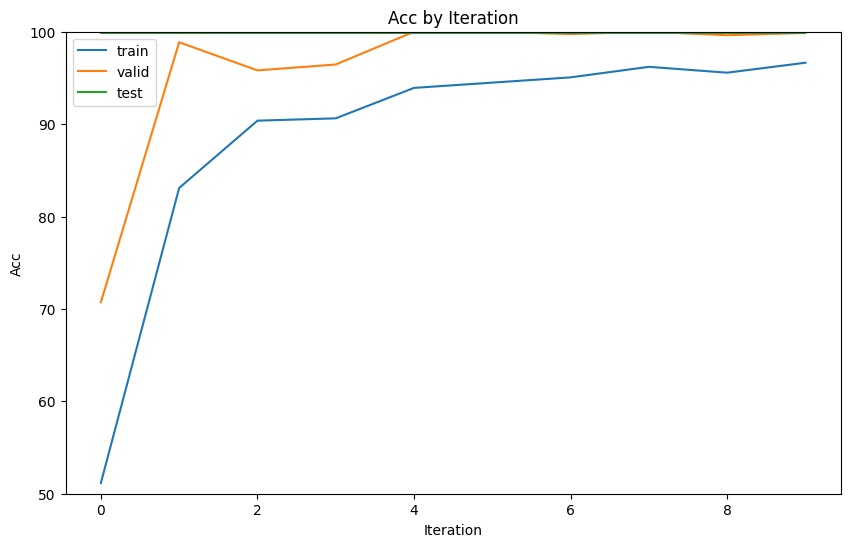

In [55]:
plot_acc(train_acc_h,val_acc_h, test_acc)

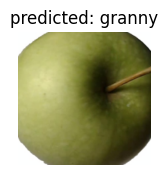

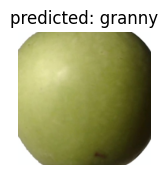

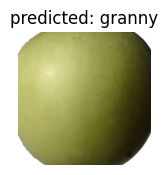

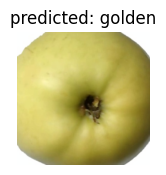

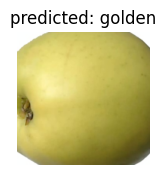

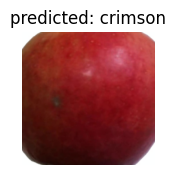

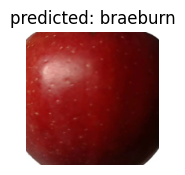

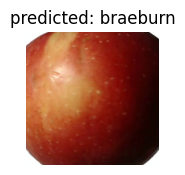

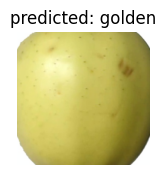

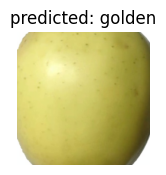

In [56]:
visualize_model(model_ft)

#### Summary of the new architecture

In [ ]:
# ADD YOUR CODE HERE

## 3. Other dadats

#### Define your loss function